In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
print(np.__version__, tf.__version__)

1.16.4 2.1.0


### Image classification, Part I

In this tutorial, we are going to learn how to build a image classifier using TensorFlow 2.x. This version of TensorFlow has some major differences from TensorFlow 1.x, so make sure you have the correct version installed. We are going to make extensive use of its high-level Keras API. As the most basic tutorial in this series, we are going to start with a simple convolutional neural network (CNN) on the Fashion MNIST dataset. Let's get started!

The Fashion MNIST dataset is contained in the TensorFlow package. It is consisted of 60,000 train images and 10,000 test images of size 28 $\times$ 28. Each image belongs to one of 10 different types of clothing. 

#### 1. Building and training a `tf.keras` model

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


Pre-processing of data is usually required. In our images, each pixel is represented with an integer between 0 and 255, so we scale all input to the range of [0, 1]

In [3]:
train_images = train_images / 255.0
test_images = test_images / 255.0

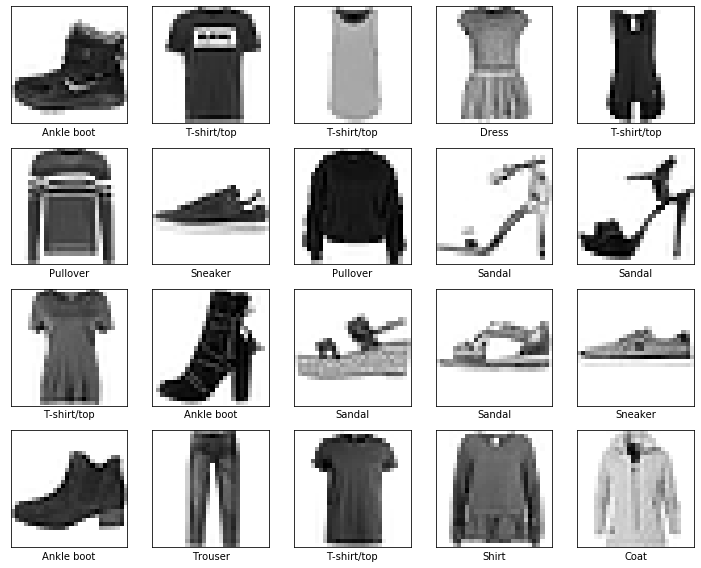

In [4]:
# Names of the 10 classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Let's take a look at the first 20 images and labels in the training set.
fig, axes = plt.subplots(4, 5)
fig.set_figheight(8)
fig.set_figwidth(10)
for ax, train_image, train_label in zip([a for ax_list in axes for a in ax_list], train_images[:20], train_labels[:20]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(train_image, cmap=plt.cm.binary)
    ax.set_xlabel(class_names[train_label])
fig.tight_layout()

Now we can build our CNN model with Keras. The simplest way to do it is to use the keras.Sequential model, which is made up of a linear stack of layers. We can pass a list of layers chosen from keras.layers to keras.Sequential, and it is as simple as that. For this task, we are going to use an architecture similar to LeNet-5, consisted of two convolutional layers, two pooling layers, and two dense layers. Let's see how this is done.

In [5]:
simpleCNN = keras.Sequential([
    keras.layers.Reshape((28, 28, 1)), # Our input do not have a channel dimension, so we need to add this by using a reshape layer
    keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='relu'), # 6 filters of size 5×5, 'same' padding
    keras.layers.MaxPool2D(pool_size=2, strides=2), # 2×2 pooling filters, stride 2
    keras.layers.Conv2D(filters=16, kernel_size=5, padding='valid', activation='relu'), # 16 filters of size 5×5, 'valid' padding
    keras.layers.MaxPool2D(pool_size=2, strides=2), # 2×2 pooling filters, stride 2
    keras.layers.Flatten(), # Flatten all 2D feature maps (3D tensors) to 1D vectors
    keras.layers.Dense(units=120, activation='relu'), # Dense layer 1, 120 neurons
    keras.layers.Dense(units=84, activation='relu'), # Dense layer 2, 84 neurons
    keras.layers.Dense(units=10), # Output layer with 10 classes, no activation, outputs logits
])

Now that we have built our model, we can compile the model. Compiling simply means defining the loss function to minimize, choosing the optimizer, and defining the metrics we would like to output for evaluation. Let's use the Adam optimizer with a cross-entropy loss function, which is usually used for multi-class classification tasks. For the metrics, we are most interested in knowing the accuracy of classification.

In [6]:
simpleCNN.compile(
    optimizer='adam', # We are using default optimizer parameters. We can also pass a `tf.keras.optimizers` instance with custom parameters.
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # We are not using one-hot representation, and we are calculating from logits.
    metrics=['accuracy'] # Everything in `tf.keras.metrics` is supported.
)

Now we are ready to train our CNN model. To do this, just call the `fit` method of the model and pass our training images and labels as arguments. For demonstration we are going to train the model for 20 epochs.

In [7]:
history = simpleCNN.fit(train_images, train_labels, epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 23s 379us/sample - loss: 0.5092 - accuracy: 0.8127
Epoch 2/20
60000/60000 [==============================] - 22s 363us/sample - loss: 0.3449 - accuracy: 0.8730
Epoch 3/20
60000/60000 [==============================] - 22s 365us/sample - loss: 0.2979 - accuracy: 0.8897
Epoch 4/20
60000/60000 [==============================] - 22s 365us/sample - loss: 0.2721 - accuracy: 0.8993
Epoch 5/20
60000/60000 [==============================] - 22s 364us/sample - loss: 0.2506 - accuracy: 0.9073
Epoch 6/20
60000/60000 [==============================] - 21s 356us/sample - loss: 0.2317 - accuracy: 0.9135
Epoch 7/20
60000/60000 [==============================] - 22s 362us/sample - loss: 0.2181 - accuracy: 0.9184
Epoch 8/20
60000/60000 [==============================] - 22s 359us/sample - loss: 0.2025 - accuracy: 0.9232
Epoch 9/20
60000/60000 [==============================] - 21s 356us/sample - loss: 0.1919 - accuracy: 0.9

We see that the model achieves an accuracy of 96.1% on the training set, which is a great result! However, how does our model perform on the test set? Let's find out by calling the `evaluate` methods and pass our test data and labels. The `fit` method returns a `History` object that stores the losses and metrics of different epochs. We can use this to plot the training progress of our model.

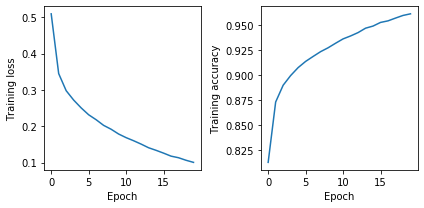

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(6)
fig.set_figheight(3)

ax1.plot(range(20), history.history['loss'])
ax1.set_ylabel('Training loss')
ax1.set_xlabel('Epoch')

ax2.plot(range(20), history.history['accuracy'])
ax2.set_ylabel('Training accuracy')
ax2.set_xlabel('Epoch')

fig.tight_layout()

We can see that our training loss decreases sharply at the first few epochs, and then continue to decrease at a steady but lower pace. Training accuracy exhibits the opposite trend, with a sharp increase at the beginning before slowering down. This is a typical good learning curve for a deep learning model.

Now we are ready to test out our trained model. To do this, we are going to evaluate our model with our test set, using the `evaluate` method of our model.

In [9]:
simpleCNN.evaluate(test_images, test_labels, verbose=2)

10000/10000 - 2s - loss: 0.3784 - accuracy: 0.9034


[0.37835311711877584, 0.9034]

We see that our model performs much better on the training set than on the test set. This indicates that our model suffers from overfitting. There are a number of ways to overcome this problem, but in this tutorial, let's focus on one of the most common strategies, which is to increase training data by data augmentation. In TensorFlow, the Keras API provides an extremely convenient way for us to augment image data, namely `ImageDataGenerator`. Let's see how this works.

#### 2. Data augmentation with `ImageDataGenerator`

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Let's reload the data
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# For training data, we still want to apply scaling, but in addition, we also want to perform horizontal flip, rotation, zooming 
# and image translation to augment our dataset. All of this can be done with a simple call of `ImageDataGenerator`.
# Because our image size is small, we do not want to process our images too heavily.
train_gen = ImageDataGenerator(rescale=1/255, # Rescale the data values
                               rotation_range=5, # Rotate at most 5 degrees
                               horizontal_flip=True, # Flip horizontally
                               zoom_range=0.05) # Shift by a factor between 0.95 and 1.05

# For the test set, we don't need to perform data augmentation, but we still need to perform scaling.
test_gen = ImageDataGenerator(rescale=1/255)

In [11]:
# Let's apply data processing to our training and test sets. Since we have a large amount of data, 
# a good idea is to perform batching. Here we choose a batch size of 128.

train_data_gen = train_gen.flow(train_images.reshape(-1, 28, 28, 1), # We need to reshape our input at this stage (add in the channel dimension)
                                train_labels, batch_size=128, shuffle=True) # Shuffle training data and generate batches of 128
test_data_gen = test_gen.flow(test_images.reshape(-1, 28, 28, 1), 
                              test_labels, batch_size=1024, shuffle=False) # Do not shuffle for test set

One important thing to note is that `ImageDataGenerator` will NOT add new images to your dataset in each epoch. Instead, it will apply the transformations you specified randomly in each epoch so your model sees something slightly differently in each epoch. This will prevent overfitting to some extent. Let's redefine our model and run the experiment again to see whether this works.

In [12]:
# Redefine and recompile model. The only difference is that here we do not need the reshape layer.

simpleCNN = keras.Sequential([
    keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters=16, kernel_size=5, padding='valid', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=120, activation='relu'),
    keras.layers.Dense(units=84, activation='relu'),
    keras.layers.Dense(units=10),
])

simpleCNN.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [13]:
# Although we have processed our data through a data generator, we can still call `fit` to train our model.
history = simpleCNN.fit(train_data_gen, epochs=20)

Train for 469 steps
Epoch 1/20
469/469 [==============================] - 16s 33ms/step - loss: 0.6901 - accuracy: 0.7472
Epoch 2/20
469/469 [==============================] - 16s 34ms/step - loss: 0.4600 - accuracy: 0.8323
Epoch 3/20
469/469 [==============================] - 17s 36ms/step - loss: 0.4058 - accuracy: 0.8512
Epoch 4/20
469/469 [==============================] - 17s 37ms/step - loss: 0.3720 - accuracy: 0.8626
Epoch 5/20
469/469 [==============================] - 17s 35ms/step - loss: 0.3505 - accuracy: 0.8709
Epoch 6/20
469/469 [==============================] - 17s 36ms/step - loss: 0.3342 - accuracy: 0.8772
Epoch 7/20
469/469 [==============================] - 17s 37ms/step - loss: 0.3199 - accuracy: 0.8815
Epoch 8/20
469/469 [==============================] - 18s 37ms/step - loss: 0.3071 - accuracy: 0.8869
Epoch 9/20
469/469 [==============================] - 17s 36ms/step - loss: 0.2982 - accuracy: 0.8897
Epoch 10/20
469/469 [==============================] - 17s 36m

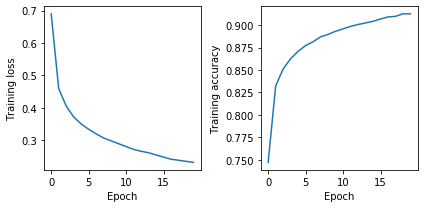

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(6)
fig.set_figheight(3)

ax1.plot(range(20), history.history['loss'])
ax1.set_ylabel('Training loss')
ax1.set_xlabel('Epoch')

ax2.plot(range(20), history.history['accuracy'])
ax2.set_ylabel('Training accuracy')
ax2.set_xlabel('Epoch')

fig.tight_layout()

In [15]:
simpleCNN.evaluate(test_data_gen)

W0505 12:30:20.507943 140693678028608 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


10/10 [==============================] - 0s 38ms/step - loss: 0.2953 - accuracy: 0.8980


[0.2953488454222679, 0.898]

We see that training performance has dropped significantly, but test performance is actually slightly better than our previous trial! There is much less of a gap between training and test performance. This means that we have overcome the problem of overfitting. However, we might actually be facing underfitting this time, since rotating, moving around or zooming a small image may actually result in the object being partially cropped out. Therefore, there is a tradeoff between variance and bias, and we should reduce overfitting while still achieving a good fit.

#### 3. Checkpoints, saving and loading models

Another way to mitigate overfitting is early stopping, where training are stopped without the model reaching a perfect fit on training data. In this case, often we may want to train the model for a number of epochs but actually use the model at a previous epoch rather than the final model. To achieve this, we can save checkpoints at the end of epochs during training. Checkpoints are also useful when you want to stop during training at one point and want to continue training at a later stage. Now let's see how we can save checkpoints during training. 

In [16]:
# `tf.keras.callbacks` contain utilities that get called at certain points of model training.
# Let's define a `tf.keras.callbacks.ModelCheckpoint` instance

# First, let's define the path for storing checkpoints. We can define a format for checkpoint file names within this path using string formatting.
# Suppose we want to store our checkpoint files as `simpleCNN-checkpoint-**.ckpt` where ** is a two-digit epoch number.
checkpoint_path = './model_checkpoints/tutorial_1/simpleCNN-checkpoint-{epoch:02d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Next, let's create a ModelCheckpoint instance to only store model weights.
# Suppose we want to save a checkpoint every 2 epochs. We can specify that as an option using the `period` argument.
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                      save_weights_only=True,
                                                      verbose=1,
                                                      period=2) # Store every 2 epochs

# Reload the data.
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

# For this example, let's go without data augmentation.
simpleCNN = keras.Sequential([
    keras.layers.Reshape((28, 28, 1)),
    keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters=16, kernel_size=5, padding='valid', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=120, activation='relu'),
    keras.layers.Dense(units=84, activation='relu'),
    keras.layers.Dense(units=10),
])

simpleCNN.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

W0505 12:30:23.731399 140693678028608 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [17]:
# During training, we can pass in our callback.

history = simpleCNN.fit(train_images, train_labels, epochs=20, callbacks=[checkpoint_callback])

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 22s 375us/sample - loss: 0.5113 - accuracy: 0.8141
Epoch 2/20
59872/60000 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8746
Epoch 00002: saving model to ./model_checkpoints/tutorial_1/simpleCNN-checkpoint-02.ckpt
60000/60000 [==============================] - 22s 363us/sample - loss: 0.3408 - accuracy: 0.8746
Epoch 3/20
60000/60000 [==============================] - 22s 368us/sample - loss: 0.2979 - accuracy: 0.8912
Epoch 4/20
59968/60000 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.9002
Epoch 00004: saving model to ./model_checkpoints/tutorial_1/simpleCNN-checkpoint-04.ckpt
60000/60000 [==============================] - 22s 372us/sample - loss: 0.2690 - accuracy: 0.9002
Epoch 5/20
60000/60000 [==============================] - 22s 374us/sample - loss: 0.2481 - accuracy: 0.9079
Epoch 6/20
59936/60000 [============================>.] - ETA: 0s - loss: 0.

As you can see from the printout, checkpoints were saved every 2 epochs into our defined directory. Let's first evaluate the final model on the test set to see the test performance.

In [18]:
simpleCNN.evaluate(test_images, test_labels, verbose=2)

10000/10000 - 2s - loss: 0.3972 - accuracy: 0.9054


[0.39719306312203406, 0.9054]

Let's say we want to use the model trained for only 16 epochs to mitigate overfitting, we can create a new model and directly load the weights from our fifth checkpoint (stored after epoch 10).

In [19]:
# Define a new model as before.
simpleCNN_epoch16 = keras.Sequential([
    keras.layers.Reshape((28, 28, 1)),
    keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Conv2D(filters=16, kernel_size=5, padding='valid', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=120, activation='relu'),
    keras.layers.Dense(units=84, activation='relu'),
    keras.layers.Dense(units=10),
])

# We still need to compile the model.
simpleCNN_epoch16.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Use the `load_weights` method of our model and pass the checkpoint path.
simpleCNN_epoch16.load_weights('./model_checkpoints/tutorial_1/simpleCNN-checkpoint-16.ckpt')

In [20]:
# Now, let's see if early stopping leads to a better test result.
simpleCNN_epoch16.evaluate(test_images, test_labels, verbose=2)

10000/10000 - 2s - loss: 0.3335 - accuracy: 0.9061


[0.333518095767498, 0.9061]

We see that test loss is slightly reduced and accuracy is slightly increased. This shows that overfitting is reduced to some extent.

We can also store the entire model into a number of formats, so that we don't need to re-create the model and load in the weights. Instead, we can just load the model and do predictions. The most commonly used formats are the SavedModel format and the HDF5 format. Let's see how to do this.

In [21]:
# To save as a SavedModel, we just need to call the `save` method of the model and provide the path for saving.

simpleCNN_epoch16.save('./trained_models/tutorial_1_simpleCNN')

W0505 12:47:29.996855 140693678028608 deprecation.py:506] From /home/sl2678/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
# We can restore a model in the SavedModel format with `tf.keras.models.load_model`.
loaded_simpleCNN = keras.models.load_model('./trained_models/tutorial_1_simpleCNN')

# Let's check if this is the model trained for 16 epochs by evaluating it on the test set.
loaded_simpleCNN.evaluate(test_images, test_labels, verbose=2)

10000/10000 - 3s - loss: 0.3335 - accuracy: 0.9061


[0.333518095767498, 0.9061]

In [23]:
# To save as a HDF5 model, we just need to provide a '.h5' suffix in our path for saving.
simpleCNN_epoch16.save('./trained_models/tutorial_1_simpleCNN.h5')

# We can restore the model using the same `load_model` function.
loaded_simpleCNN_h5 = keras.models.load_model('./trained_models/tutorial_1_simpleCNN.h5')

# Let's evaluate it on the test set.
loaded_simpleCNN_h5.evaluate(test_images, test_labels, verbose=2)

10000/10000 - 2s - loss: 0.3335 - accuracy: 0.9061


[0.333518095767498, 0.9061]

In this tutorial, we have learned how to build a simple CNN model using the `tf.keras` API, how to train the model, how to do data augmentation with `ImageDataGenerator`, and how to save checkpoints, save a model and load a model. In the next tutorial, we are going to learn how to deal with real-world images of different sizes, learn about `GradientTape`, and some other utilities.